<a href="https://colab.research.google.com/github/puckgroen/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [1]:
# Import packages

# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.impute import KNNImputer

In [7]:
# Data splitting

from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')
Y = data['label']
del data['label']

sss = model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
cv_4fold = model_selection.StratifiedKFold(n_splits=4)

count = 0 
for train_index, test_index in sss.split(data, Y):
    train_scores = []
    test_scores = []
    count += 1
    print(f'Iteration {count}')
    data_array = pd.DataFrame.from_dict(data) #Needed to be able to index this later 
    split_X_train = data_array.iloc[train_index]
    split_y_train = Y[train_index]
    split_X_test = data_array.iloc[test_index]
    split_y_test = Y[test_index]
    print(f'Training dataset size {len(split_X_train)}')
    print(f'Test dataset size {len(split_X_test)}')

    # Loop over the folds
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]
        print(f'Validation size in current fold = {len(X_validation)}')

The number of samples: 113
The number of features: 160
Iteration 1
Training dataset size 90
Test dataset size 23
Validation size in current fold = 23
Validation size in current fold = 23
Validation size in current fold = 22
Validation size in current fold = 22
Iteration 2
Training dataset size 90
Test dataset size 23
Validation size in current fold = 23
Validation size in current fold = 23
Validation size in current fold = 22
Validation size in current fold = 22
Iteration 3
Training dataset size 90
Test dataset size 23
Validation size in current fold = 23
Validation size in current fold = 23
Validation size in current fold = 22
Validation size in current fold = 22
Iteration 4
Training dataset size 90
Test dataset size 23
Validation size in current fold = 23
Validation size in current fold = 23
Validation size in current fold = 22
Validation size in current fold = 22
Iteration 5
Training dataset size 90
Test dataset size 23
Validation size in current fold = 23
Validation size in current

The data has 159 features and 113 samples/subjects. The labels are given as either T12 (low) or T34 (high). 

The aim of this study is to predict the T-stage (high/low) in patients with H&N cancer based on features, extracted from CT. A good performance on this dataset would be above 70% mean accuracy.

Train data preprocessing

In [8]:
# 1. Scaling (standard, min max, robust)

# Scale the data to be normal
scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)


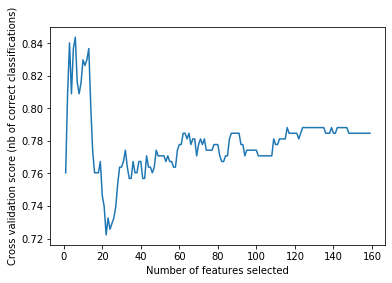

Optimal number of features : 6


In [10]:
# 2. Feature selection/extraction
# Create the Recursive Feature Elimination object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(X_train_scaled, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print("Optimal number of features : %d" % rfecv.n_features_)

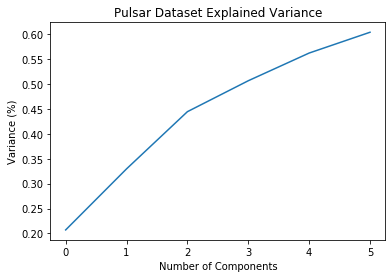

[[-2.16003726e+00 -6.59474536e+00  2.91517562e-01 -6.12131312e+00
  -1.55756956e+00  7.37976755e-01]
 [ 2.11601114e+00  1.10926126e+01 -3.54094612e+00 -1.37385721e+00
   1.73995865e+00  9.14112975e+00]
 [ 6.32856641e+00 -2.33592896e-02  4.37700847e-01 -2.71775486e+00
   1.25963648e-01 -6.22426680e+00]
 [-3.06404220e+00  3.11052264e+00 -2.75398496e+00  2.41621351e-01
   3.00929371e-01 -3.77414823e+00]
 [-6.73632580e+00  4.41122711e+00 -1.07047809e+01  2.40555458e+00
  -1.03022629e+00 -4.13474170e-01]
 [-2.84812006e+00 -2.00511939e+00  4.58422495e+00 -4.79728543e+00
   4.91160497e-01  1.85811405e+00]
 [ 1.90731692e+00 -4.50972530e+00 -1.83385828e+00 -2.07460214e+00
  -3.74831803e-01 -2.25402793e-01]
 [ 2.71763565e+00  2.39088865e+00  2.48011245e+00  2.16263219e+00
  -4.43041425e+00 -1.05703998e+00]
 [ 7.97106609e+00 -7.91508304e-01 -3.50908415e+00 -2.82984733e+00
   1.49732816e-01  8.02232182e-01]
 [ 2.21968065e+00  4.01111265e+00  3.21393700e+00  3.39258573e+00
  -4.27227944e+00 -3.3694

(68, 6)

In [29]:
# 3. PCA
n_selected_features = rfecv.n_features_
n_samples = len(X_train.index)
n_components = min(n_samples, n_selected_features)
pca = decomposition.PCA(n_components)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

print(X_train_pca)
X_train_pca.shape

In [15]:
# 4. Imputation missing data
missing_values=[0.0, 1.0]
for elem in missing_values:
    imputer = KNNImputer(missing_values=elem, n_neighbors=5, weights='uniform')
    X_train_imputed = imputer.fit_transform(X_train_pca)
print(X_train_imputed)

[[-2.16003726e+00 -6.59474536e+00  2.91517562e-01 -6.12131312e+00
  -1.55756956e+00  7.37976755e-01]
 [ 2.11601114e+00  1.10926126e+01 -3.54094612e+00 -1.37385721e+00
   1.73995865e+00  9.14112975e+00]
 [ 6.32856641e+00 -2.33592896e-02  4.37700847e-01 -2.71775486e+00
   1.25963648e-01 -6.22426680e+00]
 [-3.06404220e+00  3.11052264e+00 -2.75398496e+00  2.41621351e-01
   3.00929371e-01 -3.77414823e+00]
 [-6.73632580e+00  4.41122711e+00 -1.07047809e+01  2.40555458e+00
  -1.03022629e+00 -4.13474170e-01]
 [-2.84812006e+00 -2.00511939e+00  4.58422495e+00 -4.79728543e+00
   4.91160497e-01  1.85811405e+00]
 [ 1.90731692e+00 -4.50972530e+00 -1.83385828e+00 -2.07460214e+00
  -3.74831803e-01 -2.25402793e-01]
 [ 2.71763565e+00  2.39088865e+00  2.48011245e+00  2.16263219e+00
  -4.43041425e+00 -1.05703998e+00]
 [ 7.97106609e+00 -7.91508304e-01 -3.50908415e+00 -2.82984733e+00
   1.49732816e-01  8.02232182e-01]
 [ 2.21968065e+00  4.01111265e+00  3.21393700e+00  3.39258573e+00
  -4.27227944e+00 -3.3694